In [4]:
import numpy as np
import timeautoencoder as tae
import timediffusion as tdf
import DP as dp
import pandas as pd
import torch
import os
import time
import process_edited as pce

In [5]:
data = 'Hurricane'
filename = f'C:/Users/namjo/OneDrive/문서/GitHub/TimeAutoDiff/Dataset/Single-Sequence/Hurricane.csv'

# Read dataframe
print(filename)
real_df = pd.read_csv(filename)
real_df1 = real_df.drop('date', axis=1).iloc[0:2000,:]
real_df2= real_df.iloc[0:2000,:]

# Pre-processing Data
threshold = 1; device = 'cuda'; column_to_partition = 'Symbol'
#processed_data, time_info = dp.partition_multi_seq(real_df, threshold, column_to_partition);

processed_data = dp.splitData(real_df1, 24, threshold);
time_info = dp.splitTimeData(real_df2, processed_data.shape[1]).to(device)

##############################################################################################################################
# Auto-encoder Training
n_epochs = 50000; eps = 1e-5
weight_decay = 1e-6 ; lr = 2e-4; hidden_size = 200; num_layers = 1; batch_size = 50
channels = 64; min_beta = 1e-5; max_beta = 0.1; emb_dim = 128; time_dim = 8
lat_dim = 7; seq_col = 'Symbol'
#real_df1 = real_df1.drop(column_to_partition, axis=1)

ds = tae.train_autoencoder(real_df1, processed_data, time_info.to(device), channels, hidden_size, num_layers, lr, weight_decay, n_epochs, \
                           batch_size, threshold,  min_beta, max_beta, emb_dim, time_dim, lat_dim, device)

##############################################################################################################################
# Diffusion Training
latent_features = ds[1]; time = time_info.to(device); 
hidden_dim = 200; num_layers = 2; diffusion_steps = 100; n_epochs = 50000; num_classes = len(latent_features)
diff = tdf.train_diffusion(latent_features, time, hidden_dim, num_layers, diffusion_steps, n_epochs)

##############################################################################################################################
# Sampling new data
latent_features = ds[1]; T = latent_features.shape[1]; time_duration = []
N, _, _ = latent_features.shape
t_grid = torch.linspace(0, 1, T).view(1, -1, 1).to(device) # Note that we can use different sequence length here without any issues

samples = tdf.sample(t_grid.repeat(N, 1, 1), latent_features.detach().to(device), diff, time)  

##############################################################################################################################
# Post-process the generated data 
gen_output = ds[0].decoder(samples.to(device))  # Apply decoder to generated latent vector

data_size, seq_len, _ = latent_features.shape
synth_data = pce.convert_to_tensor(real_df1, gen_output, threshold, data_size, seq_len)
_synth_data = pce.convert_to_table(real_df1, synth_data, threshold)

##############################################################################################################################
# Draw the plots for marginal of featueres : Real v.s. Synthetic
_real_data = pce.convert_to_table(real_df1, processed_data, threshold)

# To see if you want to check latent vectors recovered well.
# B, L, K = latent_features.shape

# pd_reshaped = latent_features.reshape(B * L, K)
# sd_reshaped = samples.reshape(B * L, K)

# To see if you want to check real-data are recovered well.
B, L, K = _synth_data.shape

sd_reshaped = _synth_data.reshape(B * L, K)
pd_reshaped = _real_data.reshape(B * L, K)

real_df = pd.DataFrame(pd_reshaped.numpy())
synth_df = pd.DataFrame(sd_reshaped.numpy())

C:/Users/namjo/OneDrive/문서/GitHub/TimeAutoDiff/Dataset/Single-Sequence/Hurricane.csv


ValueError: only one element tensors can be converted to Python scalars

In [41]:
import numpy
parser = pce.DataFrameParser().fit(real_df1, threshold)
data = parser.transform()
torch.tensor(data.astype('float32')).numpy()

RuntimeError: Could not infer dtype of numpy.float32

In [43]:
data.shape

(2000, 8)

In [31]:
data = 'AirQuality'
filename = f'Data/{data}.csv'

# Read dataframe
print(filename)
real_df = pd.read_csv(filename)
real_df1 = real_df.drop('date', axis=1).iloc[0:2000,:]

_synth_data = torch.load(f'Data/AirQuality_synth.pt')
_real_data = torch.load(f'Data/AirQuality_real.pt')

B, L, K = _real_data.shape

sd_reshaped = _synth_data.reshape(B * L, K)
pd_reshaped = _real_data.reshape(B * L, K)


Data/AirQuality.csv


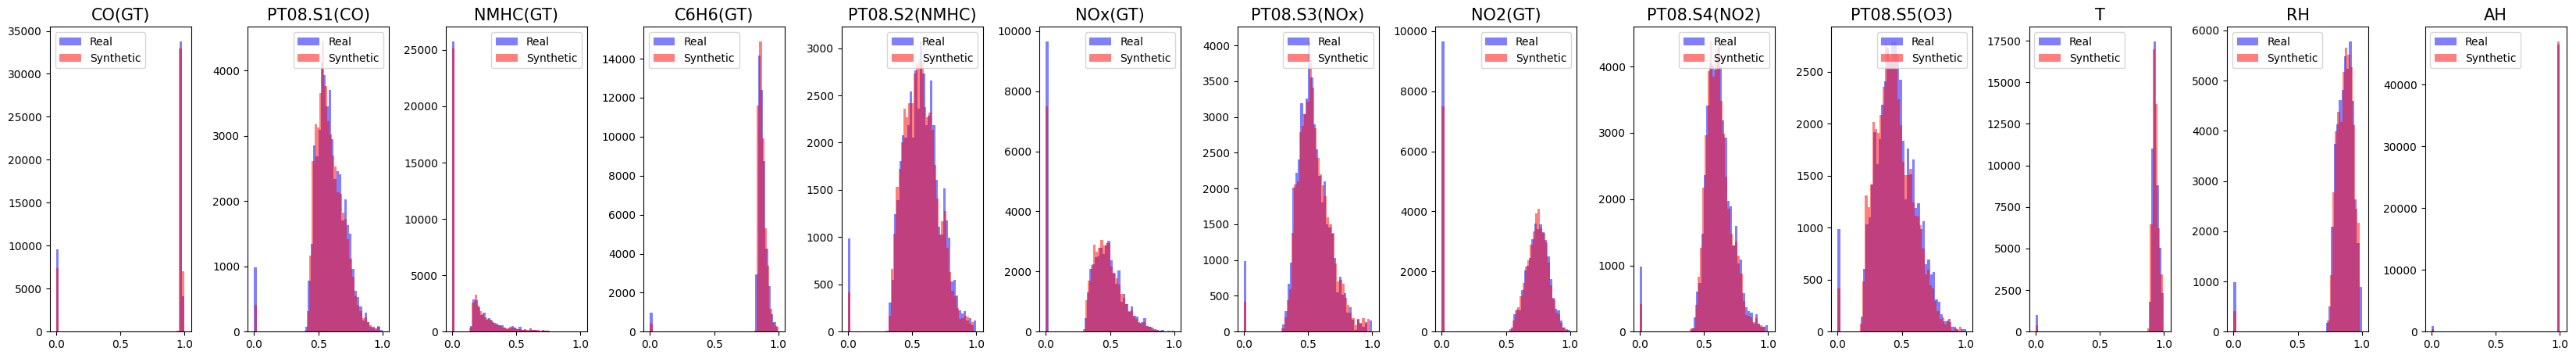

In [34]:
parser = pce.DataFrameParser().fit(real_df1, threshold)
col_name = parser.column_name()

import matplotlib.pyplot as plt
import torch
import numpy as np

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=13, figsize=(33.1, 23.4/5))

for k in range(13):
    axes[k].hist(pd_reshaped[:, k].cpu().detach(), bins=50, color='blue', alpha=0.5, label='Real')
    axes[k].hist(sd_reshaped[:, k].cpu().detach(), bins=50, color='red', alpha=0.5, label='Synthetic')

    # Adding legends
    axes[k].legend()
    axes[k].set_title(col_name[k], fontsize=15)
    
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Add space between histograms
plt.savefig('hurricane.png', dpi=500)  # Adjust dpi as needed for quality
plt.show()

In [22]:
plt.savefig('hurricane.png', dpi=500)  # Adjust dpi as needed for quality

<Figure size 640x480 with 0 Axes>